In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float() * -1 + 1
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)  # mu q(z|x)
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log-variance of q(z|x)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + std * epsilon
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    bce_loss = nn.BCELoss(reduction='sum')
    recon_loss = bce_loss(recon_x, x)
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


Epoch 1, Loss: 191.9955
Epoch 2, Loss: 166.1388
Epoch 3, Loss: 160.8071
Epoch 4, Loss: 156.9641
Epoch 5, Loss: 154.3746
Epoch 6, Loss: 152.4746
Epoch 7, Loss: 151.0656
Epoch 8, Loss: 149.6636
Epoch 9, Loss: 148.3974
Epoch 10, Loss: 147.5901
Epoch 11, Loss: 146.5811
Epoch 12, Loss: 145.8809
Epoch 13, Loss: 145.1768
Epoch 14, Loss: 144.6639
Epoch 15, Loss: 143.9738
Epoch 16, Loss: 143.5680
Epoch 17, Loss: 142.7800
Epoch 18, Loss: 142.8719
Epoch 19, Loss: 142.4154
Epoch 20, Loss: 141.8542
Epoch 21, Loss: 141.9056
Epoch 22, Loss: 141.3718
Epoch 23, Loss: 141.1309
Epoch 24, Loss: 140.8842
Epoch 25, Loss: 140.3951
Epoch 26, Loss: 140.2379
Epoch 27, Loss: 140.0169
Epoch 28, Loss: 140.1128
Epoch 29, Loss: 139.6564
Epoch 30, Loss: 139.5534


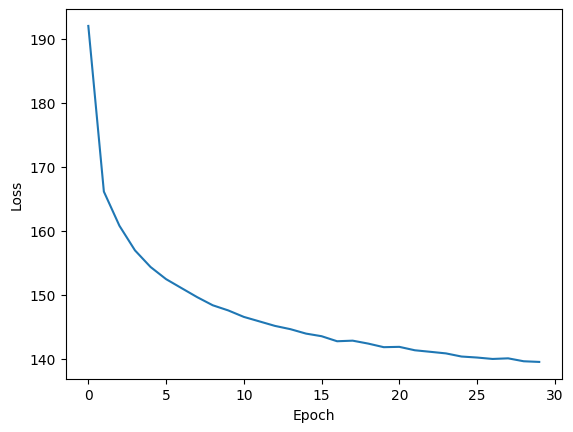

In [11]:
latent_dim = 2
vae = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 30
losses = []

vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        
        x_flattened = x.view(-1, 28 * 28)
        
        recon_x, mu, logvar = vae(x_flattened)
        recon_x_flattened = recon_x.view(-1, 28 * 28)
        
        loss = vae_loss(recon_x_flattened, x_flattened, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")
    losses.append(train_loss / len(train_loader.dataset))

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


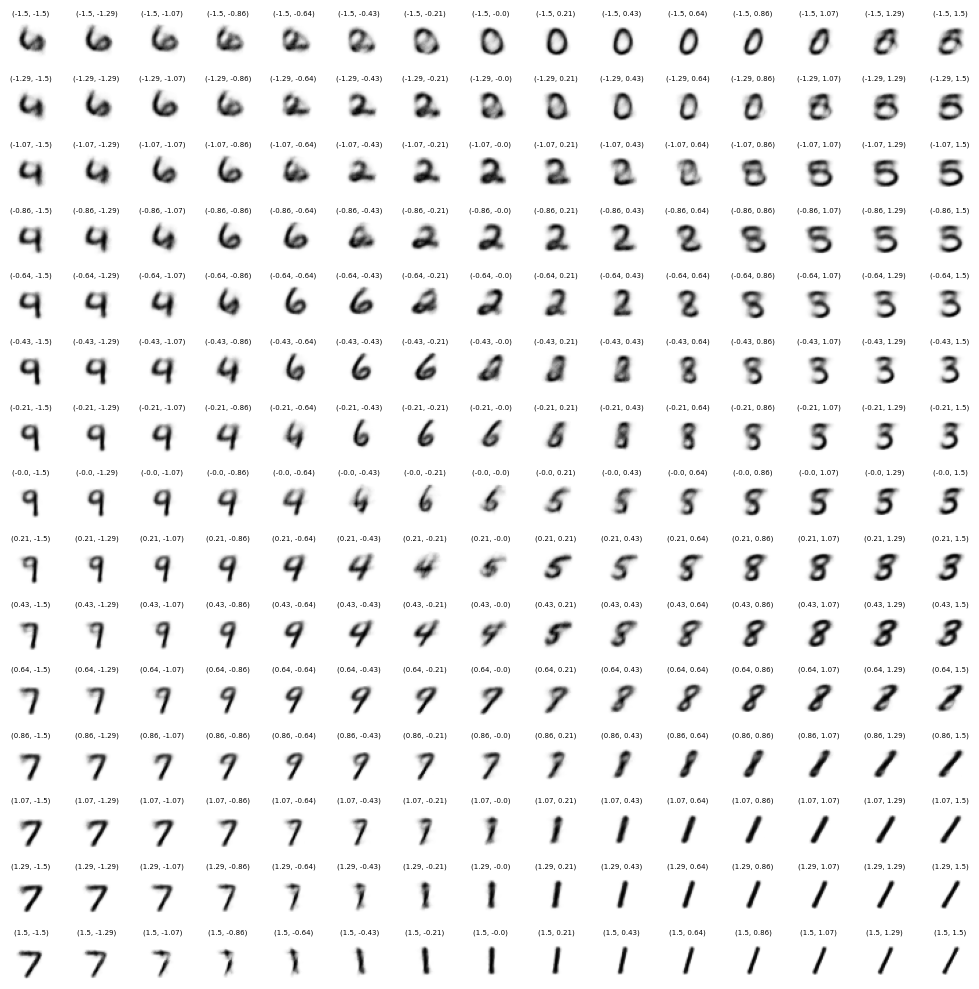

In [30]:
vae.eval()
with torch.no_grad():
    z = torch.stack([torch.tensor([i, j]) for i in torch.linspace(-1.5, 1.5, 15) for j in torch.linspace(-1.5, 1.5, 15)])
    generated_images = vae.decode(z)
    
    plt.figure(figsize=(10, 10))
    for i in range(15*15):
        plt.subplot(15, 15, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        z_val = z[i].numpy().tolist()
        z_0 = round(z_val[0], 2)
        z_1 = round(z_val[1], 2)
        plt.title((z_0, z_1), fontsize=5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()